# BART 

# setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [3]:
boston = load_boston()
features = boston["data"]
feature_names = boston["feature_names"]
labels = boston["target"]

In [4]:
df = pd.DataFrame(features)
df.columns = feature_names 
df["LABEL"] = labels

In [5]:
X = df.drop(columns=["LABEL"])
y = df["LABEL"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

# bart

In [7]:
from xbart import XBART

In [8]:
model = XBART(num_trees = 250, 
              tau =1/2,
              beta = 1.75,
              num_sweeps = 500,
              num_cutpoints = 20,
              burnin=15)

In [9]:
model.fit(X_train, y_train)

XBART(num_trees = 250, num_sweeps = 500, n_min = 1, num_cutpoints = 20, alpha = 0.95, beta = 1.75, tau = 0.5, burnin = 15, mtry = 13, max_depth_num = 250, kap = 16.0, s = 4.0, verbose = False, parallel = False, seed = 0, model_num = 0, no_split_penality = 2.995732273553991, sample_weights_flag = True, num_classes = 1)

In [10]:
# predictions 

In [11]:
predictions_mean = model.predict(X_test)  

In [12]:
predictions_posterior = model.predict(X_test, return_mean=False)  

In [13]:
# metrics 

In [14]:
from sklearn.metrics import r2_score

In [15]:
print(f"Training R^2: {r2_score(y_train, model.predict(X_train))}")

Training R^2: 0.9451010435977523


In [16]:
r2_score(y_test, predictions_mean)
print(f"Testing R^2: {r2_score(y_test, predictions_mean)}")

Testing R^2: 0.8854997851606965


Text(0.5, 1.0, 'Actual vs. Predicted')

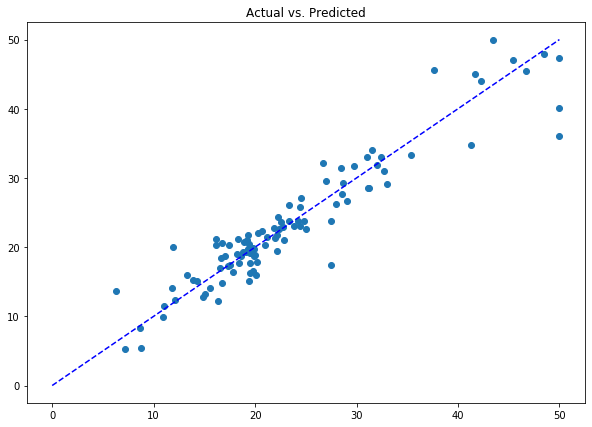

In [17]:
plt.figure(figsize=[10,7])
plt.scatter(y_test, predictions_mean)
plt.plot([0,50],[0,50], 'b--')
plt.title("Actual vs. Predicted")

In [18]:
# results

Text(0.5, 1.0, 'posterior distribution of first 10 predictions')

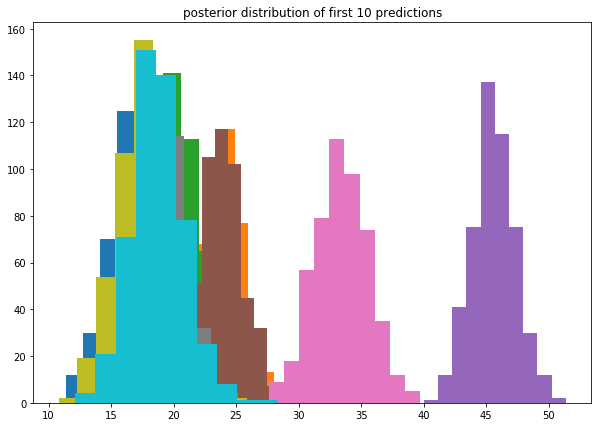

In [19]:
plt.figure(figsize=[10,7])
for x in range(0,10):
    plt.hist(predictions_posterior[x], bins=10)
plt.title("posterior distribution of first 10 predictions")

In [20]:
def prediction_intervals(predictions_posterior, percentile):
    predictions = np.array([np.mean(each) for each in predictions_posterior])
    err_down = np.array([np.percentile(each, (100 - percentile) / 2) for each in predictions_posterior])
    err_up = np.array([np.percentile(each, 100 - (100 - percentile) / 2) for each in predictions_posterior])
    return np.transpose(np.array([predictions, err_down, err_up]))

In [21]:
prediction_ints = prediction_intervals(predictions_posterior, percentile=95)

In [22]:
prediction_ints_df = pd.DataFrame(prediction_ints)
prediction_ints_df.columns = ["PREDICTION","LOWER","UPPER"]

In [23]:
prediction_ints_df

,PREDICTION,LOWER,UPPER
0,16.891668,12.922652,20.567446
1,23.785001,20.240042,27.439694
2,20.237358,16.158801,23.874748
3,19.716185,15.703549,23.650375
4,45.586394,42.313313,49.152838
...,...,...,...
97,36.116257,30.320866,41.316367
98,14.047683,10.882894,17.163633
99,19.146496,16.024865,22.025366
100,8.260885,4.926619,11.537971


In [24]:
# results

In [25]:
actual_prediction_df = pd.DataFrame({'ACTUAL' : y_test}).reset_index(drop=True)

In [26]:
results_df = pd.concat([actual_prediction_df, prediction_ints_df], axis=1)

In [27]:
results_df

,ACTUAL,PREDICTION,LOWER,UPPER
0,16.5,16.891668,12.922652,20.567446
1,24.8,23.785001,20.240042,27.439694
2,17.4,20.237358,16.158801,23.874748
3,19.3,19.716185,15.703549,23.650375
4,37.6,45.586394,42.313313,49.152838
...,...,...,...,...
97,50.0,36.116257,30.320866,41.316367
98,11.8,14.047683,10.882894,17.163633
99,19.5,19.146496,16.024865,22.025366
100,8.7,8.260885,4.926619,11.537971


In [28]:
# plot results

In [29]:
results_df_sorted = results_df.sort_values(by='ACTUAL').reset_index(drop=True)

(0, 60)

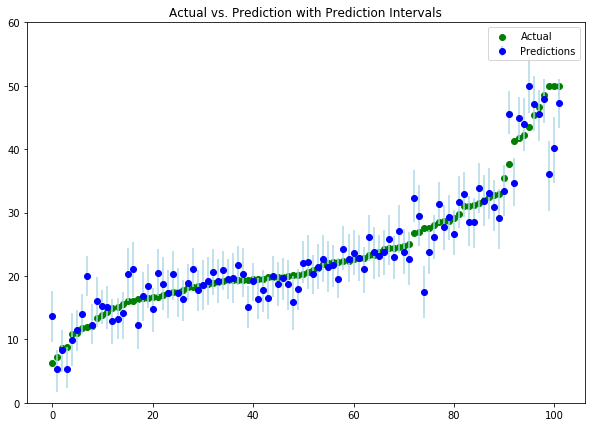

In [30]:
plt.figure(figsize=[10,7])
plt.scatter(results_df_sorted.index,
            results_df_sorted.ACTUAL,
            color='green')
plt.errorbar(results_df_sorted.index,
             results_df_sorted.PREDICTION,
             yerr=[results_df_sorted.PREDICTION - results_df_sorted.LOWER, 
                   results_df_sorted.UPPER - results_df_sorted.PREDICTION],
             ecolor='lightblue', 
             fmt='bo',
             elinewidth=0)
plt.title("Actual vs. Prediction with Prediction Intervals")
plt.legend(['Actual','Predictions'])
plt.ylim([0,60])

In [31]:
correct = 0
for each_row in results_df.itertuples():
    if each_row.LOWER <= each_row.ACTUAL <= each_row.UPPER:
        correct += 1
print(correct/results_df.shape[0])

0.8431372549019608


In [32]:
# bartpy
# xbart
# dbarts (R)